In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add
from wmpgnn.performance.reconstruction import reconstruct_decay

In [2]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
# Load the configuration
config_loader = ConfigLoader("config_files/had_heteromp_gnn_inference_B_DD.yaml", environment_prefix="DL")

In [3]:
from wmpgnn.performance.performance import Performance

In [4]:
perf = Performance(config_loader)

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:677: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,
/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:653: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fix, axs = plt.subplots(2, figsize=(10, 10))


100
200
300


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

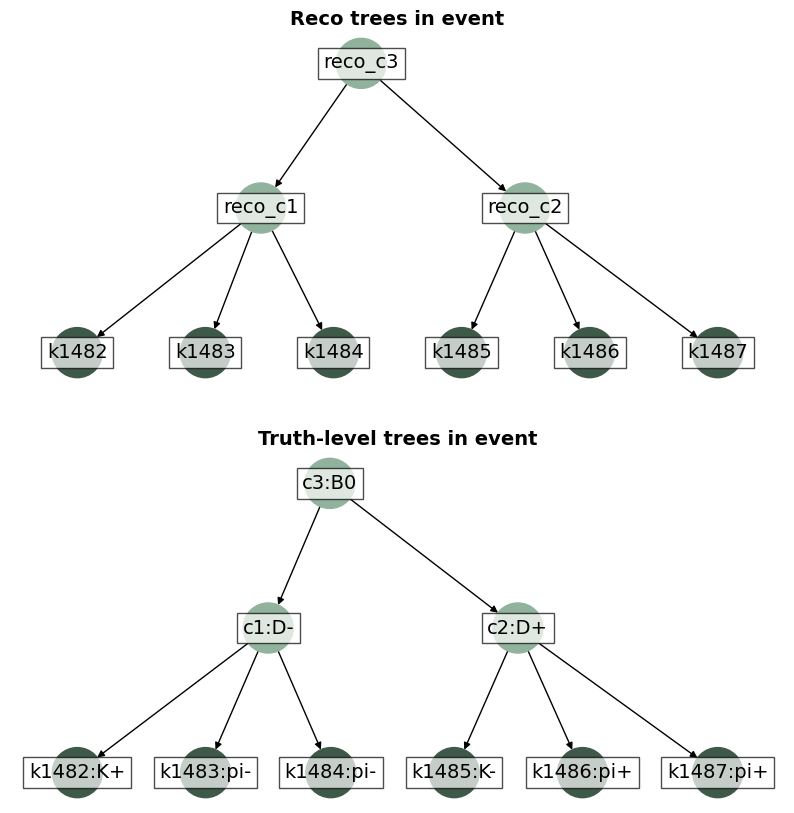

In [5]:
perf.evaluate_reco_performance(event_max=1000,pruning_cut=0.2,plot_perfect_decaychains=20)

In [6]:
perf.unset_pruning(layer=7)

In [6]:
perf.model.cuda()

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'tracks')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'tracks')): MLP(-1, 128, 128, 128, 16)
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregat

In [7]:
vdata

NameError: name 'vdata' is not defined

In [8]:
from wmpgnn.performance.reconstruction import particle_name

In [9]:
for i,vdata in enumerate(perf.dataset):
    vdata_copy = vdata.clone()
    vdata.cuda()
    vdata
    
    gout = perf.model(vdata)
    # X=torch.concat([vdata['tracks'].x[vdata[('tracks','to','pvs')].edge_index[0]],
    #                     vdata['pvs'].x[vdata[('tracks','to','pvs')].edge_index[1]],
    #                     vdata[('tracks','to','pvs')].edges], -1)

    # pv_outputs = NN(X)
    #eco_LCA = perf.lca_reco_matrix(gout)
    gout.cpu()
    vdata.cpu()
    #reco_LCA = perf.lca_reco_matrix(gout)
    reco_LCA = perf.lca_reco_matrix(gout)
    particle_keys = list(vdata["final_keys"].numpy())
    reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
    reco_LCA, particle_keys)
    
    true_LCA = perf.lca_truth_matrix(vdata)
    particle_keys = list(vdata["truth_part_keys"].numpy())
    particle_ids = list(map(particle_name, vdata['truth_part_ids'].numpy()))
    truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
    true_LCA, particle_keys, particle_ids=particle_ids, truth_level_simulation=1)
    # if i ==5:
    #     break
    if i ==17:
        break

In [56]:
reco_LCA

,senders,receivers,LCA_probs,LCA_dec
18,40,41,"[-7.8194284, 3.3343253, 3.8327794, -2.9229724]",2
19,40,42,"[-7.8762555, -0.02252786, 4.1813107, -1.7198206]",2
20,41,42,"[-7.541307, -0.3479678, 4.360999, -1.801688]",2
21,50,51,"[-6.9416957, 2.538314, 2.2001383, -1.6158283]",1
22,50,52,"[-7.5898767, 2.438168, 2.5506716, -1.7370533]",2
23,50,53,"[-10.4724245, -5.421025, 4.4966273, 0.37622207]",2
24,50,54,"[-10.3988085, -5.8016214, 4.6739254, 0.37948734]",2
25,50,55,"[-10.907682, -5.690378, 4.593779, 0.46828473]",2
26,51,52,"[-7.4638276, 2.7956834, 2.8720574, -2.1170583]",2
27,51,53,"[-7.9362392, -5.06437, 3.925505, 0.29320133]",2


In [57]:
gout

HeteroDataBatch(
  init_senders=[35914],
  init_receivers=[35914],
  init_y=[35914, 4],
  init_keys=[202],
  init_moth_ids=[17957],
  init_partids=[202],
  final_keys=[202],
  moth_ids=[17957],
  part_ids=[202],
  lca_chain=[18],
  truth_senders=[36],
  truth_receivers=[36],
  truth_y=[36, 4],
  truth_moth_ids=[18],
  truth_part_ids=[9],
  truth_part_keys=[9],
  old_y=[0, 4],
  tracks={
    x=[202, 16],
    batch=[202],
    ptr=[2],
  },
  pvs={
    x=[6, 16],
    batch=[6],
    ptr=[2],
  },
  globals={
    x=[1, 16],
    batch=[1],
    ptr=[2],
  },
  receivers={},
  senders={},
  (tracks, to, pvs)={
    edge_index=[2, 1212],
    y=[1212, 1],
    edges=[1212, 1],
  },
  (tracks, to, tracks)={
    edge_index=[2, 36],
    y=[36, 4],
    edges=[36, 4],
  }
)

In [58]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

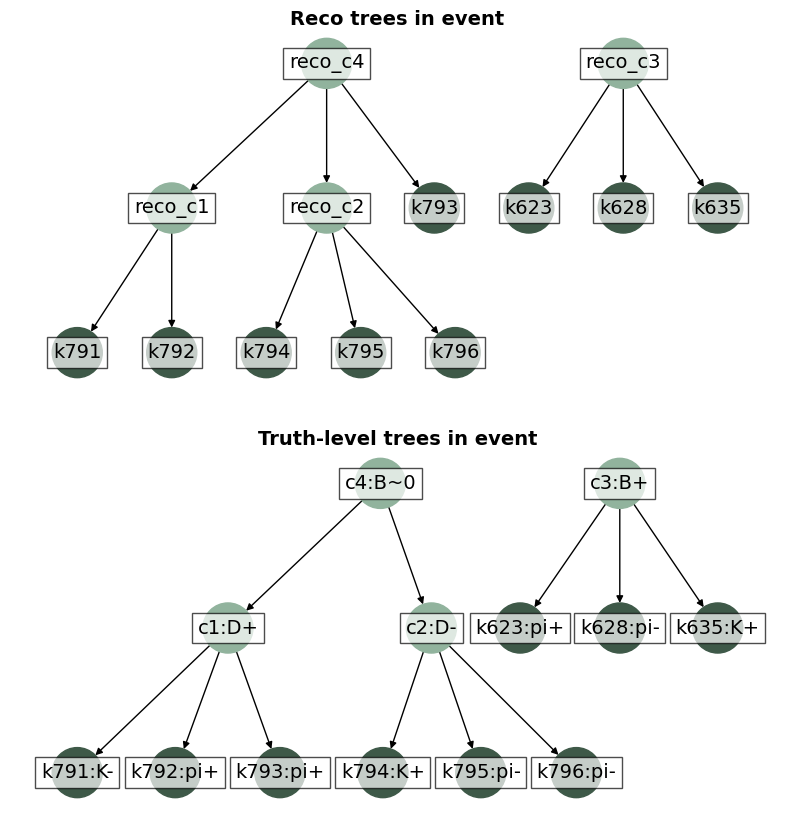

In [97]:
plt.clf()
fix, axs = plt.subplots(2, figsize=(10, 10))
axs[0].set_title('Reco trees in event',
                 fontweight='bold', fontsize=14)
particle_keys = list(vdata["final_keys"].numpy())
reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
    reco_LCA, particle_keys, axs[0])
axs[1].set_title('Truth-level trees in event',
                 fontweight='bold', fontsize=14)
#particle_keys = list(vdata["init_keys"].numpy())
#particle_ids = list(map(particle_name, vdata['init_partids'].numpy()))
particle_keys = list(vdata["truth_part_keys"].numpy())
particle_ids = list(map(particle_name, vdata['truth_part_ids'].numpy()))
truth_cluster_dict, truth_num_clusters_per_order, max_full_chain_depth_in_event = reconstruct_decay(
    true_LCA, particle_keys, axs[1], particle_ids=particle_ids, truth_level_simulation=1)
# plt.show()
plt.savefig(f"fully_reconstructed.png",dpi=300)
#plt.savefig(f"{self.results_dir}/{self.name}_perfect_reco_decay_chain_{plot_perfect_decaychains}.pdf")
#plot_perfect_decaychains = plot_perfect_decaychains - 1

In [60]:
from torch_geometric.nn.models import MLP
from torch.nn import ReLU

def mlp(output_size):
    return lambda: MLP(in_channels=-1, hidden_channels=128,  # Increased size
                       out_channels=output_size, num_layers=6, norm='batch_norm', act=ReLU())  


NN =mlp(1)()

NN.load_state_dict(torch.load('MLP_pvs.pt', weights_only=True))
NN.eval()

MLP(-1, 128, 128, 128, 128, 128, 1)

In [61]:
X=torch.concat([vdata_copy['tracks'].x[vdata_copy[('tracks','to','pvs')].edge_index[0]],
                vdata_copy['pvs'].x[vdata_copy[('tracks','to','pvs')].edge_index[1]],
                vdata_copy[('tracks','to','pvs')].edges], -1)

outputs = NN(X)

In [62]:
#gout = perf.model(vdata)

In [63]:
reco_cluster_dict

{623: {'node_keys': [623, 628, 635],
  'LCA_values': [1, 1, 1],
  'labels': ['k413',
   'k416',
   'k417',
   'k422',
   'k429',
   'k431',
   'k433',
   'k434',
   'k440',
   'k442',
   'k463',
   'k466',
   'k469',
   'k471',
   'k472',
   'k475',
   'k511',
   'k514',
   'k515',
   'k517',
   'k519',
   'k556',
   'k558',
   'k562',
   'k563',
   'k576',
   'k582',
   'k586',
   'k587',
   'k588',
   'k592',
   'k596',
   'k597',
   'k601',
   'k602',
   'k606',
   'k610',
   'k611',
   'k616',
   'k617',
   'k623',
   'k628',
   'k635',
   'k646',
   'k651',
   'k653',
   'k749',
   'k753',
   'k754',
   'k758',
   'k791',
   'k792',
   'k793',
   'k794',
   'k795',
   'k796',
   'k925',
   'k983',
   'k986',
   'k995',
   'k1002',
   'k1003',
   'k1041',
   'k1044',
   'k1046',
   'k1048',
   'k1049',
   'k1055',
   'k1069',
   'k1070',
   'k1084',
   'k1924',
   'k1929',
   'k1957',
   'k2022',
   'k2139',
   'k2144',
   'k2194',
   'k2197',
   'k2213',
   'k2216',
   'k2252',
  

In [64]:
truth_cluster_dict

{623: {'node_keys': [623, 628, 635],
  'LCA_values': [1, 1, 1],
  'labels': ['k623:pi+',
   'k628:pi-',
   'k635:K+',
   'k791:K-',
   'k792:pi+',
   'k793:pi+',
   'k794:K+',
   'k795:pi-',
   'k796:pi-',
   'c1:D+',
   'c2:D-',
   'c3:B+',
   'c4:B~0']},
 791: {'node_keys': [791, 792, 793, 794, 795, 796],
  'LCA_values': [1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1],
  'labels': ['k623:pi+',
   'k628:pi-',
   'k635:K+',
   'k791:K-',
   'k792:pi+',
   'k793:pi+',
   'k794:K+',
   'k795:pi-',
   'k796:pi-',
   'c1:D+',
   'c2:D-',
   'c3:B+',
   'c4:B~0']}}

In [65]:
node_keys = truth_cluster_dict[1862]['node_keys'] 

KeyError: 1862

In [66]:
node_keys= truth_cluster_dict[1453]['node_keys'] +  truth_cluster_dict[2052]['node_keys'] 

KeyError: 1453

In [67]:
node_keys= reco_cluster_dict[623]['node_keys'] +  reco_cluster_dict[791]['node_keys'] 

In [68]:
node_keys

[623, 628, 635, 791, 792, 793, 794, 795, 796]

In [69]:
import matplotlib.pyplot as plt

In [70]:
ind1= (node_keys[0]==vdata_copy.final_keys) | (node_keys[1]==vdata_copy.final_keys) | (node_keys[2]==vdata_copy.final_keys) | (node_keys[3]==vdata_copy.final_keys) | (node_keys[4]==vdata_copy.final_keys) | (node_keys[5]==vdata_copy.final_keys) | \
(node_keys[6]==vdata_copy.final_keys) | (node_keys[7]==vdata_copy.final_keys) #| (node_keys[8]==vdata_copy.final_keys) | (node_keys[9]==vdata_copy.final_keys) | (node_keys[10]==vdata_copy.final_keys) | (node_keys[11]==vdata_copy.final_keys) 

In [71]:
x = vdata_copy["tracks"].x[:,:3].numpy()
p = vdata_copy["tracks"].x[:,3:6].numpy()
xB = vdata_copy["tracks"].x[ind1,:3].numpy()
pB = vdata_copy["tracks"].x[ind1,3:6].numpy()

In [72]:
p_norm = p / np.sqrt(np.sum(p**2))

In [73]:
p_normB = pB / np.sqrt(np.sum(pB**2))

In [74]:
track_ids = gout[('tracks','to','pvs')].edge_index[0][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]
pv_ids = gout[('tracks','to','pvs')].edge_index[1][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]

In [75]:

b_tracks = vdata[('tracks', 'to', 'tracks')].edge_index[0][vdata[('tracks', 'to', 'tracks')].y[:, 0] == 0]

tracks = vdata[('tracks', 'to', 'tracks')].edge_index[0]
unique_b_tracks = torch.unique(b_tracks)
unique_tracks = torch.unique(tracks)

In [78]:
pv_indices = []
true_indices = []
for i in unique_tracks:
    index = (vdata[('tracks', 'to', 'pvs')].edge_index[0] == i)
    pv_indices.append(torch.argmax(
        perf.model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index]).item() )
    true_indices.append(torch.argmax(
                    vdata[('tracks', 'to', 'pvs')].y[index]))    

    

In [77]:
pv_indices = []
true_indices = []
for i in unique_tracks:
    index = (vdata[('tracks', 'to', 'pvs')].edge_index[0] == i)
    pv_indices.append(torch.argmax(
        outputs[index]).item() )
    true_indices.append(torch.argmax(
                    vdata[('tracks', 'to', 'pvs')].y[index]))


In [40]:
pv_indices = []
true_indices = []
for i in unique_tracks:
    index = (vdata[('tracks', 'to', 'pvs')].edge_index[0] == i)
    pv_indices.append(torch.argmin(
        vdata_copy[('tracks', 'to', 'pvs')].edges[index]).item() )
    true_indices.append(torch.argmax(
                    vdata[('tracks', 'to', 'pvs')].y[index]))

In [41]:
#vdata[('tracks', 'to', 'pvs')].edges[index]

In [42]:
len(unique_tracks)

202

In [43]:
#pv_indices

In [44]:
len(pv_indices)

202

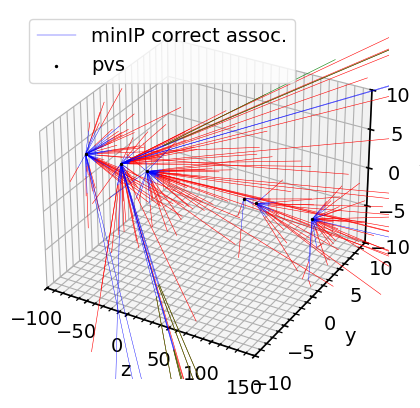

In [89]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(0,2000,2):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot3D(zline, yline, xline, 'red', linewidth=0.4)

for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(0,2000,2):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot3D(zline, yline, xline, 'green', linewidth=0.4)

count = 0
count2 = 0
for track_id, pv_id, true_id in zip(unique_tracks, pv_indices, true_indices):
    v = []
    v.append(vdata_copy['tracks'].x[track_id,:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_id,:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5) 
    if pv_id == true_id:
        color = 'blue'
    else:
        color = 'purple'
    # if count == 0:
    #     ax.plot3D(zline, yline, xline, 'blue', linewidth=0.2, label='HGNN assoc.')
    # else:
    #     ax.plot3D(zline, yline, xline, 'blue', linewidth=0.2)
    if count == 0:
        ax.plot3D(zline, yline, xline,   color, linewidth=0.3, label='minIP correct assoc.')
    elif  pv_id != true_id and count2 == 0:
        ax.plot3D(zline, yline, xline,   color, linewidth=0.3, label='minIP false assoc.')
    else:
        ax.plot3D(zline, yline, xline,   color, linewidth=0.3)
    if pv_id == true_id:
        count+=1
    if pv_id != true_id:
        count2+=1
# for i in range(track_ids.shape[0]):
#     v = []
#     v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
#     v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     # ax.set_ylim(bottom=-5,top=5)
#     # ax.set_zlim(bottom=-100,top=100)
#     # ax.set_xlim(left=-5,right=5)    
#     ax.plot3D(zline, yline, xline, 'blue', linewidth=0.2)

# for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
#     v = []
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     if i==0:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)
#     else:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)

ax.set_ylim(bottom=-10,top=10)
# ax.scatter3D(v2[0,ind],v2[1,ind],v2[2,ind])
ax.set_zlim(bottom=-10,top=10)
ax.set_xlim(left=-100,right=150)    
for i in range(0,vdata['pvs'].x.shape[0]):
    if i==0:
        ax.scatter3D(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][0].item(), c='black', s=2, label="pvs")
    else:
        ax.scatter3D(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][0].item(), c='black', s=2)
ax.set_ylabel("y")
ax.set_zlabel("x") 
ax.set_xlabel("z")   
plt.legend()
plt.savefig("dfei_event_minIP.png",dpi=300)
#ax.legend(loc='upper left')

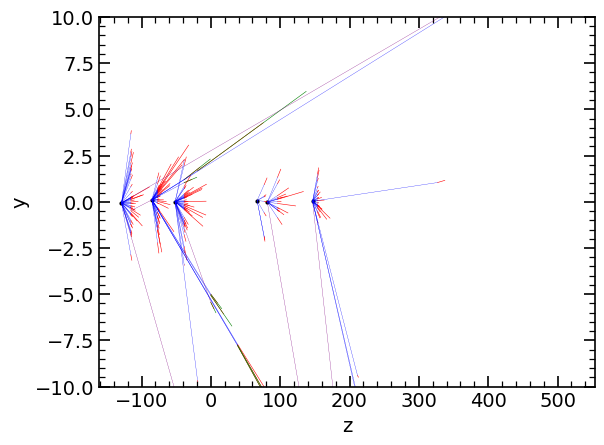

In [46]:
fig = plt.figure()
ax = plt.axes()
# Data for a three-dimensional line
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(0,200,2):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot(zline, yline, 'red', linewidth=0.4)

for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(0,200,2):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot(zline, yline, 'green', linewidth=0.4)

count = 0
for track_id, pv_id, true_id in zip(unique_tracks, pv_indices, true_indices):
    v = []
    v.append(vdata_copy['tracks'].x[track_id,:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_id,:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    if pv_id == true_id:
        color = 'blue'
    else:
        color = 'purple'
    
    if count == 0:
        ax.plot(zline, yline,  color, linewidth=0.2, label='HGNN assoc.')
    else:
        ax.plot(zline, yline,  color, linewidth=0.2)

# for i in range(track_ids.shape[0]):
#     v = []
#     v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
#     v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     # ax.set_ylim(bottom=-5,top=5)
#     # ax.set_zlim(bottom=-100,top=100)
#     # ax.set_xlim(left=-5,right=5)    
#     ax.plot(zline, yline, 'blue', linewidth=0.2)

# for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
#     v = []
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     if i==0:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)
#     else:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)

#ax.set_ylim(bottom=-10,top=10)
# ax.scatter3D(v2[0,ind],v2[1,ind],v2[2,ind])
ax.set_ylim(bottom=-10,top=10)
#ax.set_xlim(left=-100,right=100)    
for i in range(0,vdata['pvs'].x.shape[0]):
    if i==0:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=4, label="pvs")
    else:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=4)
ax.set_ylabel("y")
#ax.set_zlabel("x") 
ax.set_xlabel("z")   

plt.savefig("dfei_event_2D.png",dpi=300)

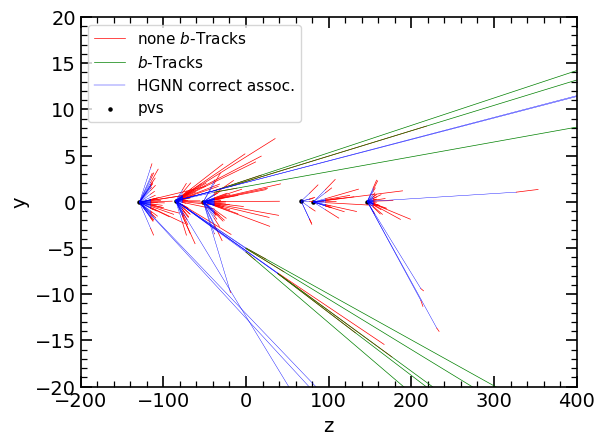

In [96]:
fig = plt.figure()
ax = plt.axes()
# Data for a three-dimensional line
count = 0
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(0,500,2):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    if count == 0:
        ax.plot(zline, yline, 'red', linewidth=0.5, label = r"none $b$-Tracks")
    else:
        ax.plot(zline, yline, 'red', linewidth=0.5)
    count += 1
    
count = 0
for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(0,20000,2):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    #ax.plot(zline, yline, 'green', linewidth=0.4)
    if count == 0:
        ax.plot(zline, yline, 'green', linewidth=0.5, label = r"$b$-Tracks")
    else:
        ax.plot(zline, yline, 'green', linewidth=0.5)        
    count += 1
count = 0
count2 = 0
for track_id, pv_id, true_id in zip(unique_tracks, pv_indices, true_indices):
    v = []
    v.append(vdata_copy['tracks'].x[track_id,:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_id,:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    if pv_id == true_id:
        color = 'blue'
    else:
        color = 'purple'
    #color='blue'
    
    if count == 0:
        ax.plot(zline, yline,  color, linewidth=0.3, label='HGNN correct assoc.')
    elif  pv_id != true_id and count2 == 0:
        ax.plot(zline, yline,  color, linewidth=0.3, label='HGNN false assoc.')
    else:
        ax.plot(zline, yline,  color, linewidth=0.3)
    if pv_id == true_id:
        count+=1
    if pv_id != true_id:
        count2+=1
# for i in range(track_ids.shape[0]):
#     v = []
#     v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
#     v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     # ax.set_ylim(bottom=-5,top=5)
#     # ax.set_zlim(bottom=-100,top=100)
#     # ax.set_xlim(left=-5,right=5)    
#     ax.plot(zline, yline, 'blue', linewidth=0.2)

# for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
#     v = []
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     if i==0:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)
#     else:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)

#ax.set_ylim(bottom=-10,top=10)
# ax.scatter3D(v2[0,ind],v2[1,ind],v2[2,ind])
ax.set_ylim(bottom=-20,top=20)
ax.set_xlim(left=-200,right=400)    
for i in range(0,vdata['pvs'].x.shape[0]):
    if i==0:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=5, label="pvs")
    else:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=5)
ax.set_ylabel("y")
#ax.set_zlabel("x") 
ax.set_xlabel("z")   
plt.legend(loc="upper left", fontsize=11)
plt.savefig("dfei_event_2D_HGNN.png",dpi=300)
plt.savefig("dfei_event_2D_HGNN.pdf")

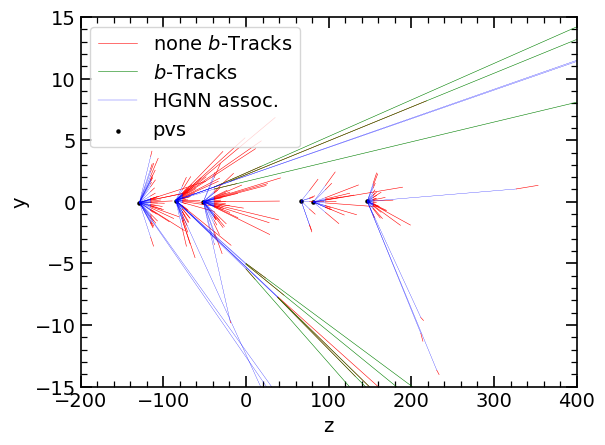

In [93]:
fig = plt.figure()
ax = plt.axes()
# Data for a three-dimensional line
count = 0
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(0,500,2):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    if count == 0:
        ax.plot(zline, yline, 'red', linewidth=0.4, label = r"none $b$-Tracks")
    else:
        ax.plot(zline, yline, 'red', linewidth=0.4)
    count += 1
    
count = 0
for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(0,20000,2):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    #ax.plot(zline, yline, 'green', linewidth=0.4)
    if count == 0:
        ax.plot(zline, yline, 'green', linewidth=0.4, label = r"$b$-Tracks")
    else:
        ax.plot(zline, yline, 'green', linewidth=0.4)        
    count += 1
count = 0
for track_id, pv_id in zip(unique_tracks, pv_indices):
    v = []
    v.append(vdata_copy['tracks'].x[track_id,:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_id,:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    if count == 0:
        ax.plot(zline, yline,  'blue', linewidth=0.2, label='HGNN assoc.')
    else:
        ax.plot(zline, yline,  'blue', linewidth=0.2)
    count += 1

# for i in range(track_ids.shape[0]):
#     v = []
#     v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
#     v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     # ax.set_ylim(bottom=-5,top=5)
#     # ax.set_zlim(bottom=-100,top=100)
#     # ax.set_xlim(left=-5,right=5)    
#     ax.plot(zline, yline, 'blue', linewidth=0.2)

# for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
#     v = []
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
#     v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
#     #print(v)
#     v = np.array(v)
#     #print(v.shape)
#     zline = v[:,2]
#     xline = v[:,0]
#     yline = v[:,1]
#     if i==0:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)
#     else:
#         ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)

#ax.set_ylim(bottom=-10,top=10)
# ax.scatter3D(v2[0,ind],v2[1,ind],v2[2,ind])
ax.set_ylim(bottom=-15,top=15)
ax.set_xlim(left=-200,right=400)    
for i in range(0,vdata['pvs'].x.shape[0]):
    if i==0:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=5, label="pvs")
    else:
        ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() , c='black', s=5)
ax.set_ylabel("y")
#ax.set_zlabel("x") 
ax.set_xlabel("z")   
plt.legend(loc="upper left")
plt.savefig("dfei_event_2D_NN.png",dpi=300)